In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud
import pandas_profiling
import missingno as msno
import datetime
import re
pd.set_option('display.width',200)
pd.set_option('display.max_colwidth',100)

## This file helps you plot more efficiently
feel free to contact me(yl3963@columbia.edu) if you have any questions


## prepare dataset

In [2]:
twitter2 = pd.read_csv("trayvontweets/Trayvon Tweets 2012.csv",encoding = "latin1", index_col = 0)

/Users/ycr/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ycr/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
twitter2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 0 to 1048574
Data columns (total 20 columns):
id                      1048575 non-null int64
message_id              1048575 non-null int64
user_handle             1048571 non-null object
orig_user_id            1048575 non-null int64
orig_user_handle        1048575 non-null object
topsy_type              1048575 non-null object
orig_date_posted_gmt    1048575 non-null float64
date_posted_gmt         1048575 non-null float64
message                 1048073 non-null object
orig_user_location      1048575 non-null object
coordinates             7480 non-null object
tweet_location          12540 non-null object
longitude               7480 non-null float64
latitude                7480 non-null float64
created_at_gmt          167805 non-null float64
seconds_after_event     1047893 non-null float64
FIPS                    1048575 non-null object
County                  1048573 non-null object
City                    1043351 

In [4]:
data_msg_time = twitter2.loc[twitter2['message'].isnull() == False,['date_posted_gmt','message']]

In [5]:
data_msg_time = data_msg_time.sample(n = 100000)
data_msg_time = data_msg_time.reset_index(drop = True)

In [6]:
def date(dates):
    delta=datetime.timedelta(days=dates)
    today=datetime.datetime.strptime('1899-12-30 00:00:00','%Y-%m-%d %H:%M:%S')+delta
    return datetime.datetime.strftime(today,'%Y-%m-%d %H:%M:%S')

In [7]:
data_msg_time['date_posted_gmt'] = data_msg_time['date_posted_gmt'].apply(lambda x: date(x))

In [8]:
data_msg_time.head()

,date_posted_gmt,message
0,2012-04-03 06:31:51,Anyone know Treyvon Martin's B-day? I'mma rock a black hoodie all day and purchase Skittles & a...
1,2012-03-22 16:33:09,"""HOUSTON RALLIES for TRAYVON!"" Mon, March 26 5pmnSHAPE Community Centern3903 Almeda, Hou, TX 77..."
2,2012-03-28 02:26:50,"@TortugaSkeptic In wake of murder of Trayvon, NRA selling ""CCW hoodie"" for concealed handgun per..."
3,2012-04-10 16:25:24,At the very least George Zimmerman needs to be convicted for feloniously poor web design; it's M...
4,2012-04-11 22:34:12,UPDATE: Associated Press reporting George Zimmerman is in custody and will be charged with secon...


### read emojis
########################
TODO 

###  function add_ymdw: add year month day  week columns for original dataframe 


In [9]:
def add_ymdw(df):
    df['date']=pd.to_datetime(df['date_posted_gmt'])

    df['year']=df['date'].apply(lambda x: x.year)

    df['month']=df['date'].apply(lambda x: x.month)

    df['day']=df['date'].apply(lambda x: x.day)
    
    def getweek(a,b,c):
        return datetime.date(a,b,c).isocalendar()[1]
    df['week'] = df.apply(lambda x: getweek(x['year'], x['month'],x['day']), axis=1)

    return df

In [10]:
data_msg_time=add_ymdw(data_msg_time)

### split dataset according to their year
you can get 3 dataframes finally

In [11]:
def split_year(df):
    df2012=df[df['year']==2012]
    df2013=df[df['year']==2013]
    df2014=df[df['year']==2014]
    return df2012,df2013,df2014

In [35]:
data_msg_time2012,data_msg_time2013,data_msg_time2014=split_year(data_msg_time)
data_msg_time2012.head()

,date_posted_gmt,message,date,year,month,day,week
0,2012-04-03 06:31:51,Anyone know Treyvon Martin's B-day? I'mma rock a black hoodie all day and purchase Skittles & a...,2012-04-03 06:31:51,2012,4,3,14
1,2012-03-22 16:33:09,"""HOUSTON RALLIES for TRAYVON!"" Mon, March 26 5pmnSHAPE Community Centern3903 Almeda, Hou, TX 77...",2012-03-22 16:33:09,2012,3,22,12
2,2012-03-28 02:26:50,"@TortugaSkeptic In wake of murder of Trayvon, NRA selling ""CCW hoodie"" for concealed handgun per...",2012-03-28 02:26:50,2012,3,28,13
3,2012-04-10 16:25:24,At the very least George Zimmerman needs to be convicted for feloniously poor web design; it's M...,2012-04-10 16:25:24,2012,4,10,15
4,2012-04-11 22:34:12,UPDATE: Associated Press reporting George Zimmerman is in custody and will be charged with secon...,2012-04-11 22:34:12,2012,4,11,15


### preprocess message

In [36]:
#change all to lower case for future regex
data_msg_time2012['message'] = data_msg_time2012['message'].str.lower()

/Users/ycr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## detect emotions

### import LIWC dictionary

In [37]:
file = open("LIWC Dictionary/LIWC_dic.txt","r")

LIWC = file.readlines()
LIWC_dict = {}
for line in LIWC:
    line = line.split(',')
    category = line[0]
    words = line[1:]
    words[0] = words[0][1:]
    words[-1] = words[-1][:-2]
    LIWC_dict[category] = words

In [38]:
LIWC_dict.keys()

dict_keys(['Function', 'Pronoun', 'Ppron', 'I', 'We', 'You', 'SheHe', 'They', 'Ipron', 'Article', 'Prep', 'Auxverb', 'Adverb', 'Conj', 'Negate', 'Verb', 'Adj', 'Compare', 'Interrog', 'Number', 'Quant', 'Affect', 'Posemo', 'Negemo', 'Anx', 'Anger', 'Sad', 'Social', 'Family', 'Friend', 'Female', 'Male', 'CogProc', 'Insight', 'Cause', 'Discrep', 'Tentat', 'Certain', 'Differ', 'Percept', 'See', 'Hear', 'Feel', 'Bio', 'Body', 'Health', 'Sexual', 'Ingest', 'Drives', 'Affiliation', 'Achieve', 'Power', 'Reward', 'Risk', 'FocusPast', 'FocusPresent', 'FocusFuture', 'Relativ', 'Motion', 'Space', 'Time', 'Work', 'Leisure', 'Home', 'Money', 'Relig', 'Death', 'Informal', 'Swear', 'Netspeak', 'Assent', 'Nonflu', 'Filler', 'Stress'])

### Adjust LIWC dictionary

In [39]:
posemo = LIWC_dict['Posemo']
for i in range(len(posemo)):
    if posemo[i][-1] == '*':
        posemo[i] = r'\b' + posemo[i][:-1]
    else:
        posemo[i] = r'\b' + posemo[i] + r'\b'
posemo[0] = '\(:'
posemo[5] = ':\)'
reg_posemo = "|".join(posemo)
reg_posemo = re.compile(reg_posemo)

In [40]:
negemo = LIWC_dict['Negemo']
for i in range(len(negemo)):
    if negemo[i][-1] == '*':
        negemo[i] = r'\b' + negemo[i][:-1]
    else:
        negemo[i] = r'\b' + negemo[i] + r'\b'
negemo[0] = '\):'
negemo[5] = ':\('
reg_negemo = "|".join(negemo)
reg_negemo = re.compile(reg_negemo)

In [41]:
anx = LIWC_dict['Anx']
for i in range(len(anx)):
    if anx[i][-1] == '*':
        anx[i] = r'\b' + anx[i][:-1]
    else:
        anx[i] = r'\b' + anx[i] + r'\b'
reg_anx = "|".join(anx)
reg_anx = re.compile(reg_anx)

In [42]:
anger = LIWC_dict['Anger']
for i in range(len(anger)):
    if anger[i][-1] == '*':
        anger[i] = r'\b' + anger[i][:-1]
    else:
        anger[i] = r'\b' + anger[i] + r'\b'
reg_anger = "|".join(anger)
reg_anger = re.compile(reg_anger)

In [43]:
sad = LIWC_dict['Sad']
for i in range(len(sad)):
    if sad[i][-1] == '*':
        sad[i] = r'\b' + sad[i][:-1]
    else:
        sad[i] = r'\b' + sad[i] + r'\b'
reg_sad = "|".join(sad)
reg_sad = re.compile(reg_sad)

In [44]:
stress = LIWC_dict['Stress']
for i in range(len(stress)):
    if stress[i][-1] == '*':
        stress[i] = r'\b' + stress[i][:-1]
    else:
        stress[i] = r'\b' + stress[i] + r'\b'
reg_stress = "|".join(stress)
reg_stress = re.compile(reg_stress)

In [45]:
reg_posemo.search("humorabc")

<re.Match object; span=(0, 5), match='humor'>

In [46]:
reg_posemo.search("happyhhh")

### function to check whether the message contains the category or not

In [47]:
def check_category(s,category,dic):
    '''
    s type: string
    category type: list of string 
    '''
    if category == 'Posemo':
        if reg_posemo.search(s):
            return category
    elif category == 'Negemo':
        if reg_negemo.search(s):
            return category
    elif category == 'Anx':
        if reg_anx.search(s):
            return category
    elif category == 'Anger':
        if reg_anger.search(s):
            return category
    elif category == 'Sad':
        if reg_sad.search(s):
            return category
    elif category == 'Stress':
        if reg_stress.search(s):
            return category
    else:
        print("only valid for six category")
    return 'NA'

In [48]:
check_category('stressed','Anx',LIWC_dict)

'Anx'

In [49]:
check_category('happy!!!','Anx',LIWC_dict)

'NA'

In [50]:
check_category('afraid','Negemo',LIWC_dict)

'Negemo'

In [51]:
check_category('confu','Negemo',LIWC_dict)

'NA'

### add_tag_col
- df:  dataframe 
- cate: list of emotion category
- dic: the dictionary stores all words belong to the category
e.g. here tag='Anx' means the message of the row contains anxiety words

In [52]:
def add_tag_col(df,cate,dic):
    for category in cate:
        df[category]=df.apply(lambda x: check_category(x['message'],category,dic),axis=1)
    return df

In [53]:
data_msg_time2012.head()

,date_posted_gmt,message,date,year,month,day,week
0,2012-04-03 06:31:51,anyone know treyvon martin's b-day? i'mma rock a black hoodie all day and purchase skittles & a...,2012-04-03 06:31:51,2012,4,3,14
1,2012-03-22 16:33:09,"""houston rallies for trayvon!"" mon, march 26 5pmnshape community centern3903 almeda, hou, tx 77...",2012-03-22 16:33:09,2012,3,22,12
2,2012-03-28 02:26:50,"@tortugaskeptic in wake of murder of trayvon, nra selling ""ccw hoodie"" for concealed handgun per...",2012-03-28 02:26:50,2012,3,28,13
3,2012-04-10 16:25:24,at the very least george zimmerman needs to be convicted for feloniously poor web design; it's m...,2012-04-10 16:25:24,2012,4,10,15
4,2012-04-11 22:34:12,update: associated press reporting george zimmerman is in custody and will be charged with secon...,2012-04-11 22:34:12,2012,4,11,15


In [54]:
emotions = ['Sad','Anx','Anger','Negemo','Posemo','Stress']
data_msg_time2012=add_tag_col(data_msg_time2012,emotions,LIWC_dict)  
data_msg_time2012.head()

/Users/ycr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date_posted_gmt,message,date,year,month,day,week,Sad,Anx,Anger,Negemo,Posemo,Stress
0,2012-04-03 06:31:51,anyone know treyvon martin's b-day? i'mma rock a black hoodie all day and purchase skittles & a...,2012-04-03 06:31:51,2012,4,3,14,NA,NA,NA,NA,NA,NA
1,2012-03-22 16:33:09,"""houston rallies for trayvon!"" mon, march 26 5pmnshape community centern3903 almeda, hou, tx 77...",2012-03-22 16:33:09,2012,3,22,12,NA,NA,NA,NA,NA,NA
2,2012-03-28 02:26:50,"@tortugaskeptic in wake of murder of trayvon, nra selling ""ccw hoodie"" for concealed handgun per...",2012-03-28 02:26:50,2012,3,28,13,NA,NA,Anger,Negemo,Posemo,NA
3,2012-04-10 16:25:24,at the very least george zimmerman needs to be convicted for feloniously poor web design; it's m...,2012-04-10 16:25:24,2012,4,10,15,NA,NA,Anger,Negemo,NA,NA
4,2012-04-11 22:34:12,update: associated press reporting george zimmerman is in custody and will be charged with secon...,2012-04-11 22:34:12,2012,4,11,15,NA,NA,Anger,Negemo,NA,NA


## Plot emotions in 2012

In [55]:
df_all_week = data_msg_time2012.groupby('week')['message'].count()
df_all_week

week
1        18
8        20
9        50
10      155
11     1911
12    32368
13    23141
14     4837
15    10971
16     2900
17     2032
18      826
19      717
20     1895
21      605
22      950
23      523
24      984
25      812
26      475
27     1082
28      474
29     1498
30      456
31      238
32      304
33      371
34      258
35      608
36      256
37      310
38      326
39      176
40      171
41      203
42      384
43      219
44      162
45      257
46      210
47      124
48      306
49      543
50      195
51      247
52      207
Name: message, dtype: int64

Most of the data are from week28. So we will plot from week 28.

### plot_count_trend function
- df: the dataframe contains at least **message,week, tag** cols

- cate: the category of emotion e.g. anxiety='anx

In [56]:
def plot_count_trend(df,category):
    df_category_week = pd.DataFrame()
    for cate in category:
        df_cate_week=df[df[cate]==cate].groupby('week')['message'].count()    
        df_cate_week = pd.DataFrame(df_cate_week)
        df_cate_week.columns = [cate]
        df_category_week = pd.concat([df_category_week,df_cate_week],axis = 1)
    plt.figure(figsize=(20,8))
    plt.xlabel('week in 2012',size=20)
    plt.ylabel('tweet num',size=20)
    # gca stands for 'get current axis'
    ax = plt.gca()
    df_category_week.plot(kind='line',ax=ax,fontsize=20)
    return df_category_week

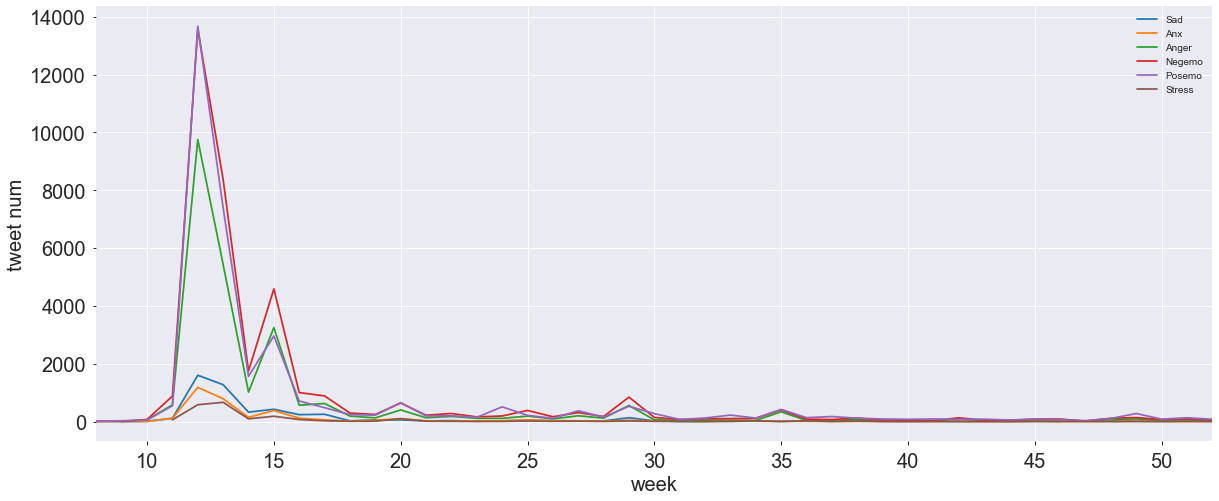

In [67]:
df_cate_week = plot_count_trend(data_msg_time2012.loc[data_msg_time2012['week']>=8],emotions)

### plot_fraction_trend
- df: the dataframe contains at least **message,week,tag cols**
- cate: the category of emotion e.g. anxiety='anx
- title: graph title
- xlabel: graph xlabel

In [68]:
df_cate_week = pd.concat([df_cate_week,df_all_week[df_all_week.index>=8]],axis = 1)

In [69]:
for cate in  emotions:
    df_cate_week[cate] = df_cate_week[cate]/df_cate_week['message']*100
df_cate_week = df_cate_week.drop(columns='message')

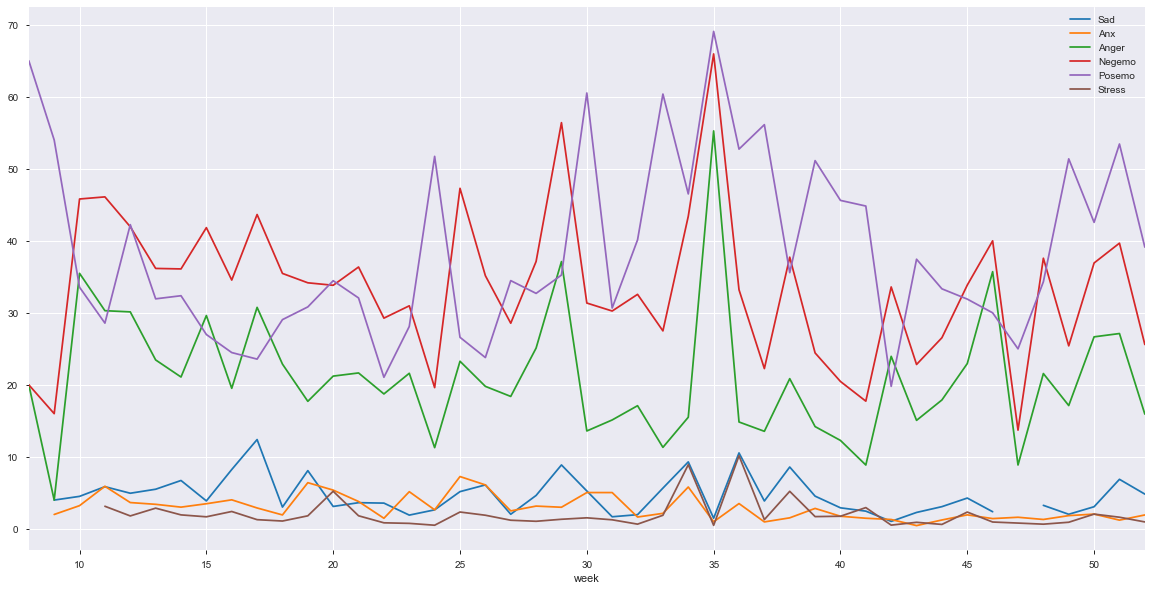

In [80]:
df_cate_week.plot(figsize=(20,10))

In [71]:
df_cate_week.corr()

,Sad,Anx,Anger,Negemo,Posemo,Stress
Sad,1.000000,0.338469,0.046632,0.311852,-0.060574,0.548524
Anx,0.338469,1.000000,0.006944,0.283722,-0.255694,0.350452
Anger,0.046632,0.006944,1.000000,0.880871,-0.112134,-0.149379
Negemo,0.311852,0.283722,0.880871,1.000000,-0.148597,0.123558
Posemo,-0.060574,-0.255694,-0.112134,-0.148597,1.000000,0.150830
Stress,0.548524,0.350452,-0.149379,0.123558,0.150830,1.000000


## Plot emotions in week 8 - week 20

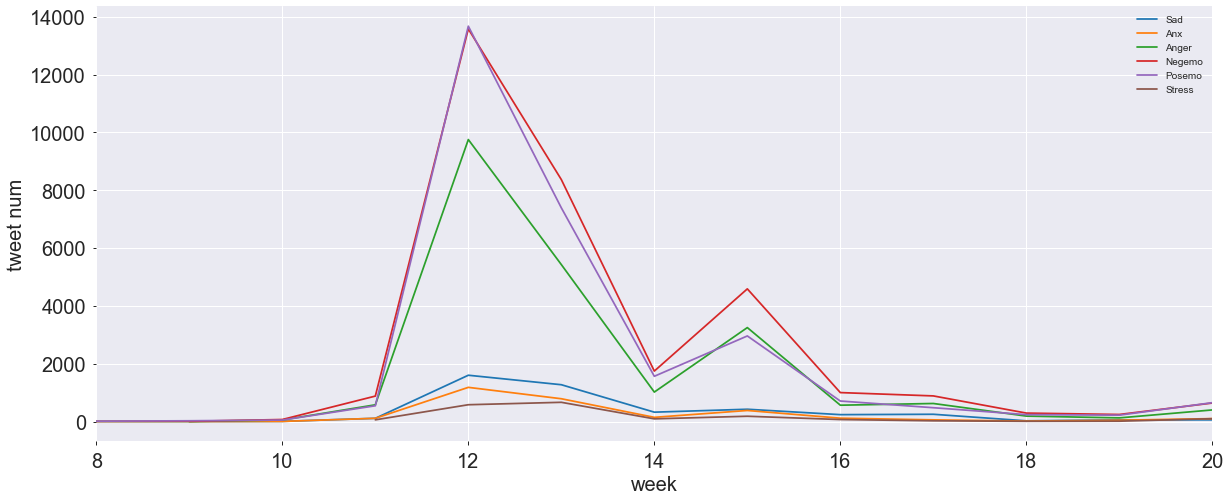

In [72]:
df_cate_week_narrow = plot_count_trend(data_msg_time2012.loc[(data_msg_time2012['week']>=8)& (data_msg_time2012['week']<=20)],emotions)


In [73]:
df_cate_week_narrow = pd.concat([df_cate_week_narrow,df_all_week[(df_all_week.index>=8) & (df_all_week.index<=20)]],axis = 1)
for cate in  emotions:
    df_cate_week_narrow[cate] = df_cate_week_narrow[cate]/df_cate_week_narrow['message']*100
df_cate_week_narrow = df_cate_week_narrow.drop(columns='message')

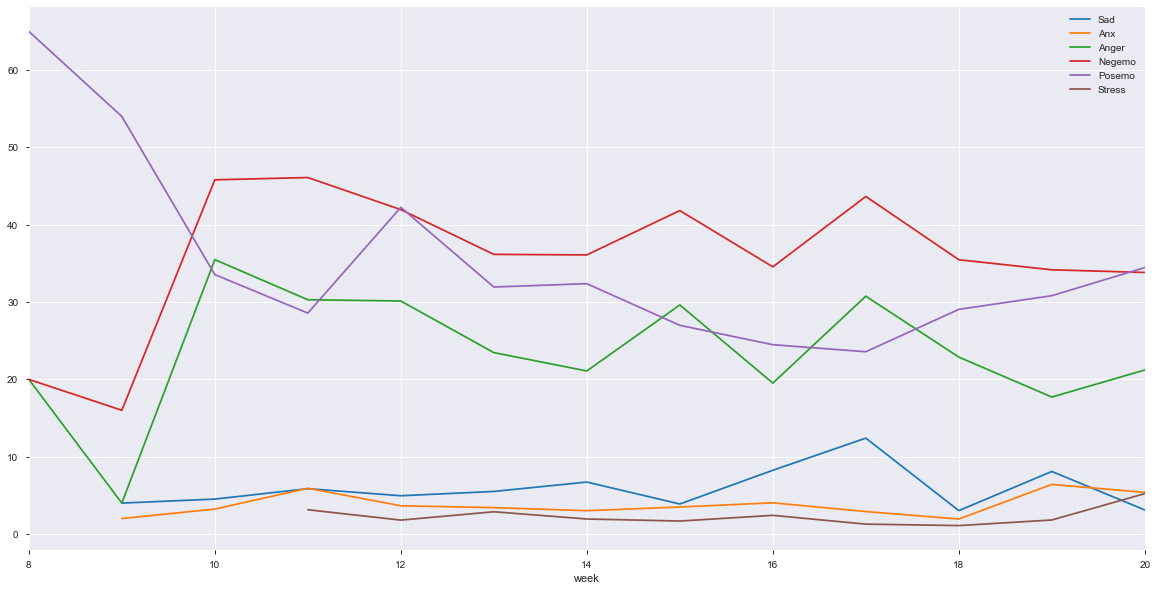

In [74]:
df_cate_week_narrow.plot(figsize=(20,10))

In [75]:
df_cate_week_narrow_corr = df_cate_week_narrow.corr()

In [79]:
df_cate_week_narrow_corr

,Sad,Anx,Anger,Negemo,Posemo,Stress
Sad,1.000000,0.136273,0.134014,0.237993,-0.469360,-0.322735
Anx,0.136273,1.000000,0.126875,0.271968,-0.271392,0.535892
Anger,0.134014,0.126875,1.000000,0.893254,-0.468291,-0.063831
Negemo,0.237993,0.271968,0.893254,1.000000,-0.765556,-0.052905
Posemo,-0.469360,-0.271392,-0.468291,-0.765556,1.000000,0.073900
Stress,-0.322735,0.535892,-0.063831,-0.052905,0.073900,1.000000


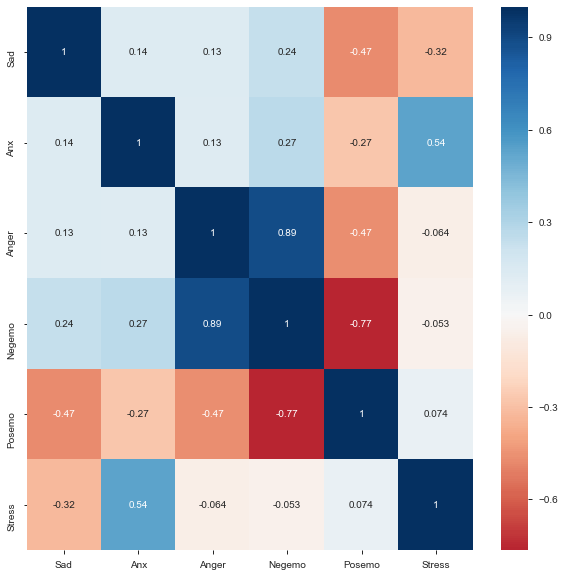

In [76]:
plt.figure(figsize=(10,10))
sns.heatmap(df_cate_week_narrow.corr(),annot=True,center=0,cmap='RdBu')